# Customer behaviour estimation

Our goal is to retain customers by predicting customer churn values. 
Our strategy is to have better performance on the customers that can leave (churn value = 1).

## 1. Packages

In [1]:
import io 
import pandas as pd
from google.colab import files # for uploading the file to colab
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split # split dataset into training and test sets 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # create conf_mtx, plot conf_mtx
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. Load data

In [2]:
 # Data can be downloaded from Kaggle, dataset: Telco Customer Churn
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['customer_churn.csv']))
df.head()
# Data size: 7043-by-21

Saving customer_churn.csv to customer_churn (9).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data cleaning, formatting

In [3]:
# customerID has unique categorical values
# Not relevant as a feature for classification: remove from dataframe.
df.drop('customerID', axis = 1, inplace = True)

# For categorical data, replace blanks by underscores.
def removeblank_in_str_items(df):
  df.replace(' ', '_', regex=True, inplace = True)
removeblank_in_str_items(df)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [4]:
# Handling missing data: identify missing values and set to 0
print(len(df.loc[df['TotalCharges']=='_']))
df.loc[(df['TotalCharges']=='_'), 'TotalCharges'] = 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
print(df.dtypes)

11
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


## 4. Train-test split, stratification

In [5]:
X = df.drop('Churn', axis = 1).copy()
y = df['Churn'].copy()
y.replace('Yes', 1, regex=True, inplace = True) 
y.replace('No', 0, regex=True, inplace = True)
print(X.head())
print(y.head())

   gender  SeniorCitizen  ... MonthlyCharges TotalCharges
0  Female              0  ...          29.85        29.85
1    Male              0  ...          56.95      1889.50
2    Male              0  ...          53.85       108.15
3    Male              0  ...          42.30      1840.75
4  Female              0  ...          70.70       151.65

[5 rows x 19 columns]
0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64


In [6]:
# Convert categorical variables into dummy/indicator variables.
print("Columns: ", df.columns)
X_enc = pd.get_dummies(X, columns = ['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'])
X_enc.head()

Columns:  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


Due to imbalanced dataset, stratification will be applied to the training and validation sets.

In [7]:
len_data = len(y)
num_of_pos_data = sum(y)
num_of_neg_data = len_data - num_of_pos_data
df_classes = pd.DataFrame(data = [num_of_pos_data/len_data*100, 100*(num_of_neg_data/len_data)], columns = ["% of classes"], index = ["1","0"])
print(df_classes)
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state = 26, stratify = y)
data_train = lgb.Dataset(data = X_train, label=y_train)
## UPDATE ACCORDING TO TRAINING DATA
num_of_pos_data = sum(y_train)
num_of_neg_data = len(y_train) - num_of_pos_data

print(f"Train ratio of #1: {sum(y_train)/len(y_train)}, Test ratio of #1: {sum(y_test)/len(y_test)}")

   % of classes
1     26.536987
0     73.463013
Train ratio of #1: 0.2654297614539947, Test ratio of #1: 0.26519023282226006


## 2. Prediction

In [8]:
def performance_evaluation(y_test, y_pred):
  accuracy=accuracy_score(y_pred,y_test)
  print("Accuracy: ", accuracy)
  cm = confusion_matrix(y_test, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual: 0', 'Actual: 1'], 
                                  index=['Predict: 0', 'Predict: 1'])

  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Accuracy:  0.7773992049971608


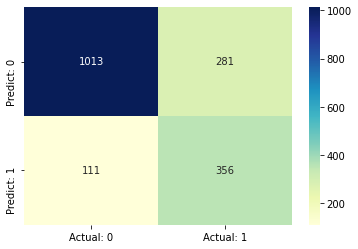

In [9]:
clf_lgb = LGBMClassifier(boosting_type='gbdt',
                         eval_metric = 'auc',
                         max_depth = -1, 
                         learning_rate = 0.05,
                         reg_lambda= 10, 
                         n_estimators = 32,
                         num_leaves = 31,
                         scale_pos_weight= num_of_neg_data/num_of_pos_data
                         )
#scale_pos_weight= 3.2
clf_lgb.fit(X_train, y_train)
y_pred = clf_lgb.predict(X_test)

performance_evaluation(y_test, y_pred)

## 4. Parameter Tuning

In [10]:
param_grid ={
    'max_depth': [8, 10, 12],
    'learning_rate': [0.01, 0.02, 0.1],
    'reg_lambda': [0.7, 0.8, 0.9],
    'scale_pos_weight': [ 2.4, 2.6, 2.8],
    'num_leaves': [31, 41, 63]
}
lgb_classifier = LGBMClassifier(boosting_type='gbdt',  objective='binary', eval_metric='auc')
optimal_parameters = GridSearchCV(estimator=lgb_classifier, 
                                  param_grid=param_grid,
                                  scoring ='roc_auc',
                                  verbose = 0,
                                  cv = 3)
optimal_parameters.fit(X_train, y_train, early_stopping_rounds =  10, 
            eval_set = [(X_train, y_train), (X_test, y_test)], 
            eval_metric = 'auc', verbose = False)
print(optimal_parameters.best_params_)

{'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 31, 'reg_lambda': 0.7, 'scale_pos_weight': 2.4}


## 5. Final Result 

Accuracy:  0.760931289040318


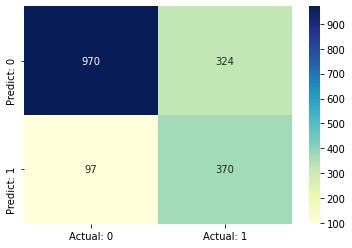

In [11]:
# Substitute the optimal parameters
clf_lgb = LGBMClassifier(boosting_type='gbdt',
                         eval_metric = 'auc',
                         max_depth = 12, 
                         learning_rate = 0.1,
                         reg_lambda= 0.7, 
                         n_estimators = 100,
                         num_leaves = 31,
                         scale_pos_weight= 2.9
                         )
# scale_pos_weight is chosen for better performance on class 1.
clf_lgb.fit(X_train, y_train)
y_pred = clf_lgb.predict(X_test)
performance_evaluation(y_test, y_pred)
